# Assigment 3 - GraphSage

For this assignment, we'll go through a simple example of how to use GraphSage's algorithm in a similar fashion as [Assignment 1](https://github.com/thmosqueiro/graph-attention-net-genomics-public/blob/main/notebooks/Chapter%201%20-%20Pytorch%20Intro.ipynb). Like before, getting 10 pts in this assignment gives you 100% grade. There are two extra points you can get if you want to go above and beyond (or if you want to catch up from a previous assignment).

For more info:
* https://snap.stanford.edu/graphsage/
* https://arxiv.org/pdf/1706.02216

The original publication uses Tensorflow. PyG (Pytorch Geommetric) implements solutions for Graph NNs, and include GraphSage:
* https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GraphSAGE.html
Here's their implementation of GraphSage (which is reproduced below):
* https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/basic_gnn.html#GraphSAGE

In case you need to install pyg:

In [1]:
pip install torch_geometric


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader

In [3]:
# model definition
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

In [4]:
# dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


* **Question 1 (1 pt):** Visualize the training data using a classical dimensionality reduction technique.

Use `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')` if you'd like to use CUDA.

In [5]:
# Setting up the model
model = GraphSAGE(dataset.num_node_features, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

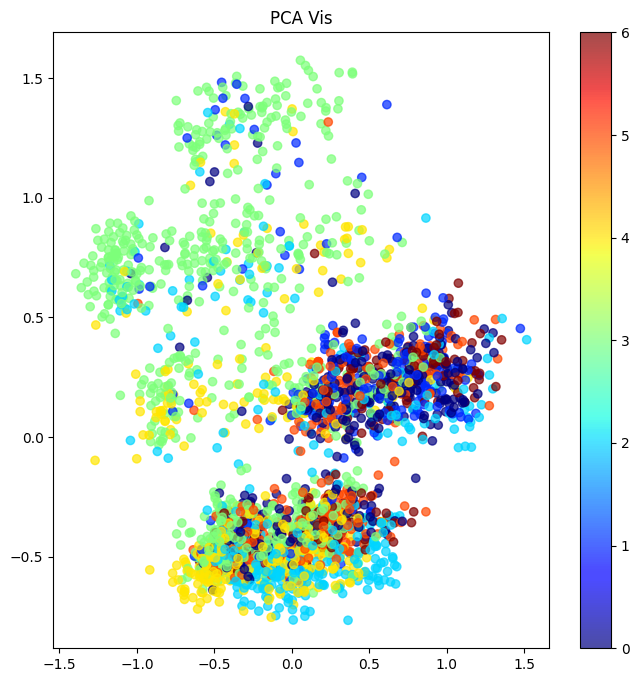

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = dataset[0] 
features = data.x
labels = data.y 

# pca
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# visualize the data
plt.figure(figsize=(8, 8))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='jet', alpha=0.7)
plt.colorbar(scatter)
plt.title('PCA Vis')
plt.show()


* **Question 2 (1 pt):** What's "weight decay"?

Weight decay is a regularization technique that involves adding a penalty term to the loss function to discourage large weights. This helps prevent the model from overfitting the training data by reducing the model’s complexity.

In [8]:
# Defining a training step
def train():
    model.train()
    optimizer.zero_grad()
    out = model(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model.eval()
    with torch.no_grad():
        out = model(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc

In [9]:
# Run one iteration
train()
acc = test()
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.5150


/Users/ayinfly/anaconda3/envs/dsc80/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [10]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.618
Accuracy on epoch 2: 0.659
Accuracy on epoch 3: 0.673
Accuracy on epoch 4: 0.679
Accuracy on epoch 5: 0.681
Accuracy on epoch 6: 0.68
Accuracy on epoch 7: 0.682
Accuracy on epoch 8: 0.685
Accuracy on epoch 9: 0.691
Accuracy on epoch 10: 0.693
Accuracy on epoch 11: 0.692
Accuracy on epoch 12: 0.687
Accuracy on epoch 13: 0.695
Accuracy on epoch 14: 0.692
Accuracy on epoch 15: 0.694
Accuracy on epoch 16: 0.695
Accuracy on epoch 17: 0.696
Accuracy on epoch 18: 0.698
Accuracy on epoch 19: 0.696
Accuracy on epoch 20: 0.695
Accuracy on epoch 21: 0.695
Accuracy on epoch 22: 0.697
Accuracy on epoch 23: 0.697
Accuracy on epoch 24: 0.698
Accuracy on epoch 25: 0.7
Accuracy on epoch 26: 0.7
Accuracy on epoch 27: 0.7
Accuracy on epoch 28: 0.701
Accuracy on epoch 29: 0.699
Accuracy on epoch 30: 0.699
Accuracy on epoch 31: 0.698
Accuracy on epoch 32: 0.699
Accuracy on epoch 33: 0.701
Accuracy on epoch 34: 0.702
Accuracy on epoch 35: 0.701
Accuracy on epoch 36: 0.702
Accuracy

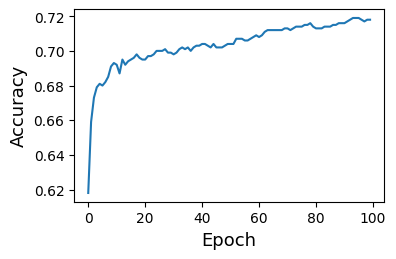

In [11]:
import pylab as pl
f, ax = pl.subplots(1, 1, figsize=(4, 2.5))
ax.plot(accuracy, '-')
ax.set_xlabel("Epoch", fontsize=13)
ax.set_ylabel("Accuracy", fontsize=13)
pl.show()

## Questions

* **Question 3 (1 pt):** Is this model predicting all classes equally well? Demonstrate differences by using any well known way of quantifying accuracy across multiple classes.

* **Question 4 (1 pt):** Compare this GraphSage with models from Weekly Assignment 2.

* **Question 5 (2 pt):** Change the aggregation function to `max`. What's the default?

* **Question 6 (2 pt):** Add one more layer to the model and investigate the performance change.

* **Question 7 (2 pt):** Add drop-out to this NN and show the impact to performance. How does it change the ROC curve.

* **Question 8 (4 pt):** Instead of using the Cora dataset, apply GraphSage to any other dataset of your choice.


## * **Question 3 (1 pt):** Is this model predicting all classes equally well? Demonstrate differences by using any well known way of quantifying accuracy across multiple classes.


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# Defining a test step
def test3():
    model.eval()
    with torch.no_grad():
        out = model(dataset.data)
        pred = out.argmax(dim=1)
        pred_test = pred[dataset.data.test_mask]
        true_test = dataset.data.y[dataset.data.test_mask]

        acc = (pred_test == true_test).sum().item() / dataset.data.test_mask.sum().item()
        print(f"Overall Accuracy: {acc:.4f}")

        conf_matrix = confusion_matrix(true_test.cpu(), pred_test.cpu())
        print("Confusion Matrix:")
        print(conf_matrix)

        print("Classification Report:")
        print(classification_report(true_test.cpu(), pred_test.cpu(), zero_division=0))

test3()

Overall Accuracy: 0.7180
Confusion Matrix:
[[ 95   6   2   6   9   7   5]
 [  5  78   3   2   0   2   1]
 [  3   9 117   5   1   2   7]
 [ 24  26   9 199  38  14   9]
 [  8   3   3   9 119   5   2]
 [  9   9   4   2   0  71   8]
 [  9   2   0   4   3   7  39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       130
           1       0.59      0.86      0.70        91
           2       0.85      0.81      0.83       144
           3       0.88      0.62      0.73       319
           4       0.70      0.80      0.75       149
           5       0.66      0.69      0.67       103
           6       0.55      0.61      0.58        64

    accuracy                           0.72      1000
   macro avg       0.69      0.73      0.70      1000
weighted avg       0.74      0.72      0.72      1000



/Users/ayinfly/anaconda3/envs/dsc80/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Class 2 is predicted very well, with high precision and recall.
Class 1 has high recall but low precision, meaning the model tends to over-predict this class.
Class 3, despite having the most samples, has a low recall (62%), meaning the model misses many true instances.
Class 6 has the worst performance, with the lowest precision (55%) and F1-score (0.58).
Overall the classes are not predicted equally well.

## * **Question 4 (1 pt):** Compare this GraphSage with models from Weekly Assignment 2.

The graphsage aggregates features from neighboring nodes using different aggregation techniques while the GCN uses layers that aggregative information from neighbors by applying convolution over the graph. The Node2Vec learns embeddings using random walks which is followed by a classifier. This allows GraphSAGE to work well on large graphs sicne it samples neighbors but GCN usess all adjacents so it is less scalable. Node2VEC uses random walks which is different from GraphSAGE or GCN

## * **Question 5 (2 pt):** Change the aggregation function to `max`. What's the default?


In [16]:
# model definition
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = SAGEConv(in_channels, out_channels, aggr='max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv(x, edge_index)
        return F.log_softmax(x, dim=1)

the default is mean

## * **Question 6 (2 pt):** Add one more layer to the model and investigate the performance change.

In [22]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='max')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='max')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [20]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(dataset.data)
    loss = F.nll_loss(out[dataset.data.train_mask], dataset.data.y[dataset.data.train_mask])
    loss.backward()
    optimizer.step()

# Defining a test step
def test():
    model.eval()
    with torch.no_grad():
        out = model(dataset.data)
        pred = out.argmax(dim=1)
        flag_is_correct = pred[dataset.data.test_mask] == dataset.data.y[dataset.data.test_mask]
        acc = int(flag_is_correct.sum()) / int(dataset.data.test_mask.sum())
        return acc

In [27]:
# Setting up the model
model = GraphSAGE(dataset.num_node_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [28]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.377
Accuracy on epoch 2: 0.583
Accuracy on epoch 3: 0.644
Accuracy on epoch 4: 0.626
Accuracy on epoch 5: 0.648
Accuracy on epoch 6: 0.669
Accuracy on epoch 7: 0.685
Accuracy on epoch 8: 0.698
Accuracy on epoch 9: 0.702
Accuracy on epoch 10: 0.711
Accuracy on epoch 11: 0.724
Accuracy on epoch 12: 0.733
Accuracy on epoch 13: 0.734
Accuracy on epoch 14: 0.736
Accuracy on epoch 15: 0.73
Accuracy on epoch 16: 0.736
Accuracy on epoch 17: 0.739
Accuracy on epoch 18: 0.745
Accuracy on epoch 19: 0.742
Accuracy on epoch 20: 0.743
Accuracy on epoch 21: 0.741
Accuracy on epoch 22: 0.744
Accuracy on epoch 23: 0.747
Accuracy on epoch 24: 0.749
Accuracy on epoch 25: 0.749
Accuracy on epoch 26: 0.749
Accuracy on epoch 27: 0.75
Accuracy on epoch 28: 0.75
Accuracy on epoch 29: 0.753
Accuracy on epoch 30: 0.753
Accuracy on epoch 31: 0.753
Accuracy on epoch 32: 0.753
Accuracy on epoch 33: 0.752
Accuracy on epoch 34: 0.752
Accuracy on epoch 35: 0.752
Accuracy on epoch 36: 0.752
Accu

With two layers, the model can aggregate information from a larger neighborhood which captures more meaningful patterns and allows the accuracy to go up.

## * **Question 7 (2 pt):** Add drop-out to this NN and show the impact to performance. How does it change the ROC curve.

In [30]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr='max')
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr='max')
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [31]:
# Setting up the model
model = GraphSAGE(dataset.num_node_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [32]:
# Run for a few epochs:
accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

/Users/ayinfly/anaconda3/envs/dsc80/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Accuracy on epoch 1: 0.187
Accuracy on epoch 2: 0.362
Accuracy on epoch 3: 0.53
Accuracy on epoch 4: 0.639
Accuracy on epoch 5: 0.698
Accuracy on epoch 6: 0.706
Accuracy on epoch 7: 0.66
Accuracy on epoch 8: 0.665
Accuracy on epoch 9: 0.669
Accuracy on epoch 10: 0.688
Accuracy on epoch 11: 0.708
Accuracy on epoch 12: 0.733
Accuracy on epoch 13: 0.754
Accuracy on epoch 14: 0.76
Accuracy on epoch 15: 0.768
Accuracy on epoch 16: 0.77
Accuracy on epoch 17: 0.771
Accuracy on epoch 18: 0.773
Accuracy on epoch 19: 0.771
Accuracy on epoch 20: 0.772
Accuracy on epoch 21: 0.767
Accuracy on epoch 22: 0.763
Accuracy on epoch 23: 0.76
Accuracy on epoch 24: 0.758
Accuracy on epoch 25: 0.76
Accuracy on epoch 26: 0.763
Accuracy on epoch 27: 0.766
Accuracy on epoch 28: 0.772
Accuracy on epoch 29: 0.767
Accuracy on epoch 30: 0.763
Accuracy on epoch 31: 0.75
Accuracy on epoch 32: 0.74
Accuracy on epoch 33: 0.729
Accuracy on epoch 34: 0.729
Accuracy on epoch 35: 0.728
Accuracy on epoch 36: 0.729
Accuracy 

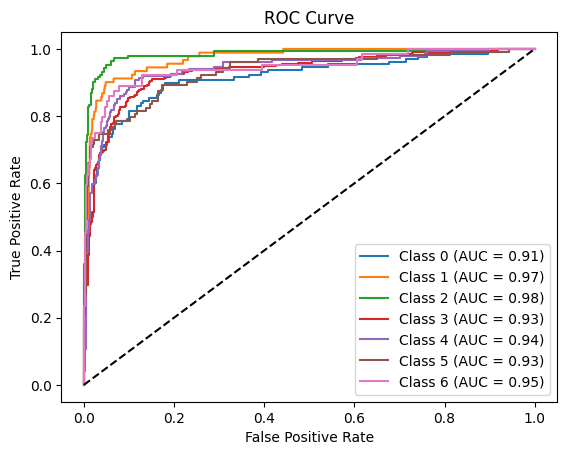

In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch.nn.functional as F

def plot_roc_curve(model, data, num_classes):
    model.eval()
    with torch.no_grad():
        out = model(data) 
        out_probs = out[data.test_mask].exp().cpu().numpy()
        true_labels = F.one_hot(data.y[data.test_mask], num_classes=num_classes).cpu().numpy()

        fpr, tpr, roc_auc = {}, {}, {}

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], out_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure()
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--') 
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

plot_roc_curve(model, data, num_classes=dataset.num_classes)


the model does better on

## * **Question 8 (4 pt):** Instead of using the Cora dataset, apply GraphSage to any other dataset of your choice.

In [56]:
dataset = Planetoid(root='/tmp/PubMed', name='PubMed')
data = dataset[0]

In [57]:
# Setting up the model
model = GraphSAGE(dataset.num_node_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [58]:
accuracy = []
for epoch in range(100):
    train()
    accuracy.append(test())
    print(f'Accuracy on epoch {epoch+1}: {accuracy[-1]}')

Accuracy on epoch 1: 0.425
Accuracy on epoch 2: 0.481
Accuracy on epoch 3: 0.498
Accuracy on epoch 4: 0.514
Accuracy on epoch 5: 0.564
Accuracy on epoch 6: 0.622
Accuracy on epoch 7: 0.658
Accuracy on epoch 8: 0.687
Accuracy on epoch 9: 0.692
Accuracy on epoch 10: 0.709
Accuracy on epoch 11: 0.723
Accuracy on epoch 12: 0.729
Accuracy on epoch 13: 0.737
Accuracy on epoch 14: 0.738
Accuracy on epoch 15: 0.743
Accuracy on epoch 16: 0.744
Accuracy on epoch 17: 0.748
Accuracy on epoch 18: 0.75
Accuracy on epoch 19: 0.748
Accuracy on epoch 20: 0.743
Accuracy on epoch 21: 0.74
Accuracy on epoch 22: 0.741
Accuracy on epoch 23: 0.743
Accuracy on epoch 24: 0.74
Accuracy on epoch 25: 0.742
Accuracy on epoch 26: 0.753
Accuracy on epoch 27: 0.756
Accuracy on epoch 28: 0.757
Accuracy on epoch 29: 0.757
Accuracy on epoch 30: 0.767
Accuracy on epoch 31: 0.768
Accuracy on epoch 32: 0.767
Accuracy on epoch 33: 0.768
Accuracy on epoch 34: 0.765
Accuracy on epoch 35: 0.76
Accuracy on epoch 36: 0.758
Accur

I chose the PubMed dataset, a citation network dataset that is part of the Planetoid benchmark suite. The dataset represents scientific publications as nodes and citation links between them as edges, forming a graph structure. Each node in the graph corresponds to a publication from the PubMed database, and the edges capture citation relationships between these publications.